<h1>  projet de clasification des images OCT de la maladie de la retine  </h1>


In [91]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import libraire pytorch pour entrainer un model vgg16
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.model_selection import train_test_split    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# import librairie pour la gestion des images
import cv2

# import librairie pour la gestion des fichiers
import os

# import librairie pour la gestion des fichiers
import glob




In [92]:
# import de data
data_train = 'archive/oct2017/OCT2017 /train'
data_test = 'archive/oct2017/OCT2017 /test'
data_val = 'archive/oct2017/OCT2017 /val'

print(len(os.listdir(data_train)))
print(len(os.listdir(data_test)))
print(len(os.listdir(data_val)))

4
5
5


In [93]:
# choisir 1500 images pour chaque classe pour l'entrainement data_train

CNV = glob.glob(data_train + '/CNV/*.jpeg')
DME = glob.glob(data_train + '/DME/*.jpeg')
DRUSEN = glob.glob(data_train + '/DRUSEN/*.jpeg')
NORMAL = glob.glob(data_train + '/NORMAL/*.jpeg')

print(len(DME))
print(len(CNV))
print(len(DRUSEN))
print(len(NORMAL))

9848
35705
7116
24815


In [94]:
# choix des 1500 images pour chaque classe
import shutil
import random
random.shuffle(CNV)
random.shuffle(DME)
random.shuffle(DRUSEN)
random.shuffle(NORMAL)

CNV = CNV[:1500]
DME = DME[:1500]
DRUSEN = DRUSEN[:1500]
NORMAL = NORMAL[:1500]

# stocker les images dans un dossier data_train_new
data_train_new = 'archive/oct2017/OCT2017 /data_train_new'
if not os.path.exists(data_train_new):
    os.makedirs(data_train_new)
    os.makedirs(data_train_new + '/CNV')
    os.makedirs(data_train_new + '/DME')
    os.makedirs(data_train_new + '/DRUSEN')
    os.makedirs(data_train_new + '/NORMAL')

# copier les images dans le dossier data_train_new
for i in CNV:
    shutil.copy(i, data_train_new + '/CNV')
for i in DME:
    shutil.copy(i, data_train_new + '/DME')
for i in DRUSEN:
    shutil.copy(i, data_train_new + '/DRUSEN')
for i in NORMAL:
    shutil.copy(i, data_train_new + '/NORMAL')


In [95]:
print(len(os.listdir(data_train_new + '/CNV')))
print(len(os.listdir(data_train_new + '/DME')))
print(len(os.listdir(data_train_new + '/DRUSEN')))
print(len(os.listdir(data_train_new + '/NORMAL')))

4291
3850
3617
4237


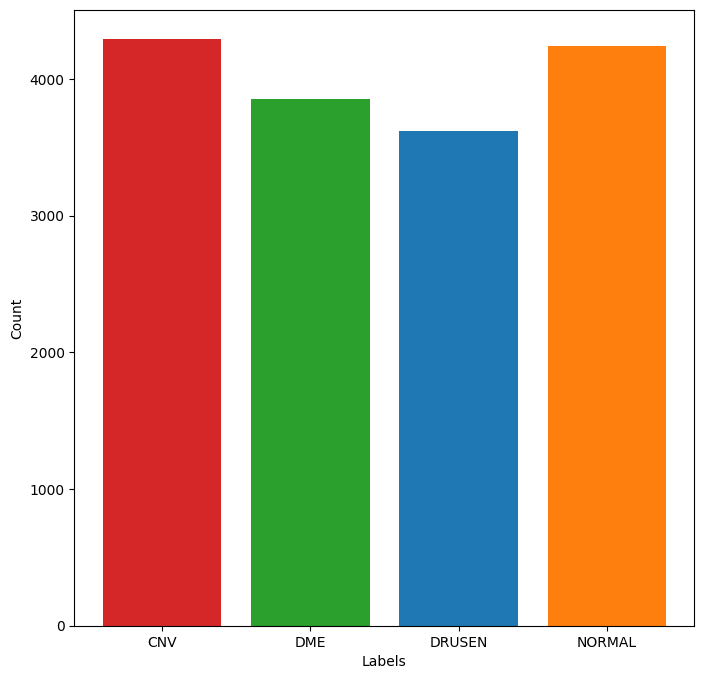

In [96]:
# plot data_train_new avec seaborn
data_train_new = 'archive/oct2017/OCT2017 /data_train_new'
CNV = glob.glob(data_train_new + '/CNV/*.jpeg')
DME = glob.glob(data_train_new + '/DME/*.jpeg')
DRUSEN = glob.glob(data_train_new + '/DRUSEN/*.jpeg')
NORMAL = glob.glob(data_train_new + '/NORMAL/*.jpeg')

data = {'CNV': len(CNV), 'DME': len(DME), 'DRUSEN': len(DRUSEN), 'NORMAL': len(NORMAL)}
label = list(data.keys())
count = list(data.values())

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(label, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

Text(0.5, 1.0, 'NORMAL')

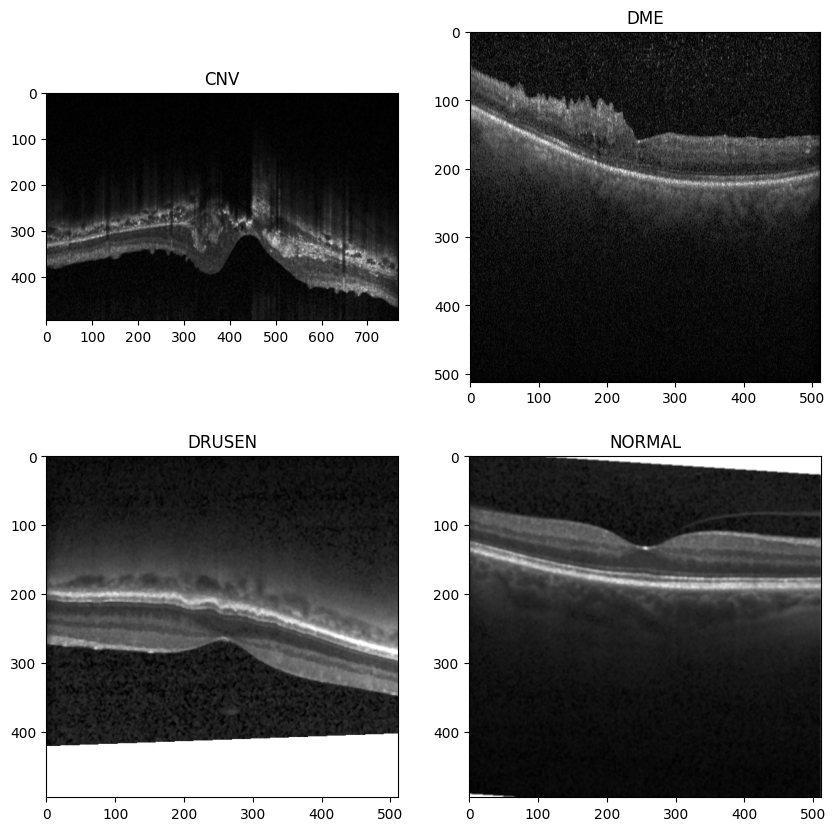

In [97]:
# plot data_train_new
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.imread(CNV[0]))
plt.title('CNV')
plt.subplot(2, 2, 2)
plt.imshow(cv2.imread(DME[0]))
plt.title('DME')
plt.subplot(2, 2, 3)
plt.imshow(cv2.imread(DRUSEN[0]))
plt.title('DRUSEN')
plt.subplot(2, 2, 4)
plt.imshow(cv2.imread(NORMAL[0]))
plt.title('NORMAL')

    

In [98]:
# augmentation des données pour le data_train_new  pour avoir 15000 images pour chaque classe
import random
import cv2
import albumentations as A

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
    ], p=0.9),

    A.OneOf([
        A.Blur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
    ], p=0.9),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
    ], p=0.9),
])

In [100]:
# applique l'augmentation des données sur les images du data_train_new pour avoir 15000 images pour chaque classe
data_train_new = CNV + DME + DRUSEN + NORMAL
for i in range(len(data_train_new)):
    img = cv2.imread(data_train_new[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = aug(image=img)
    img = augmented['image']
    cv2.imwrite(data_train_new[i], img)


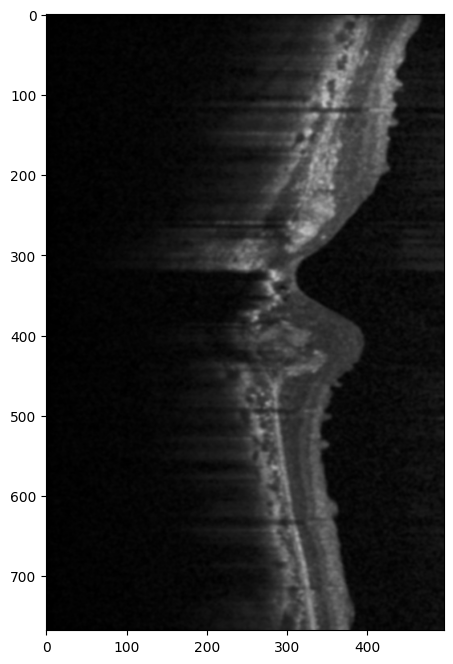

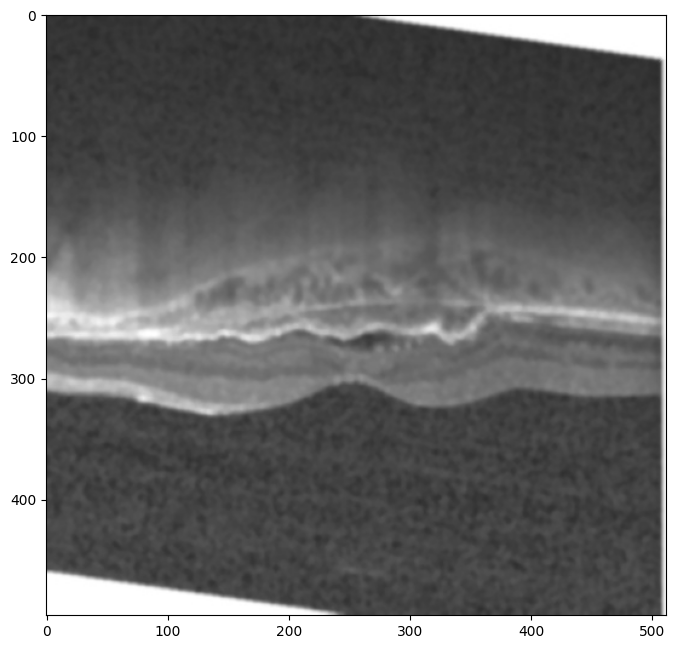

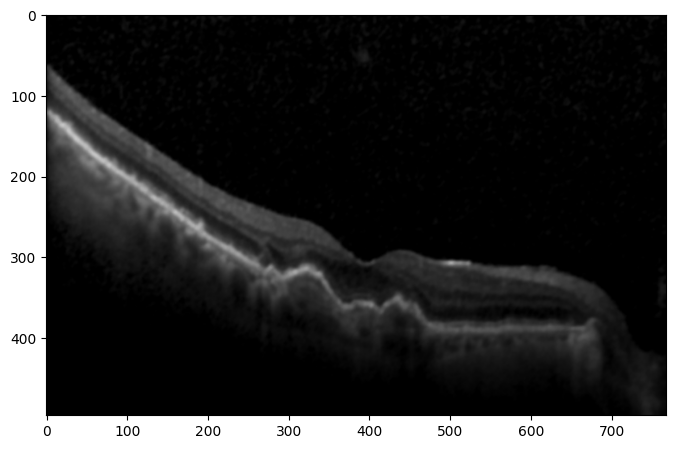

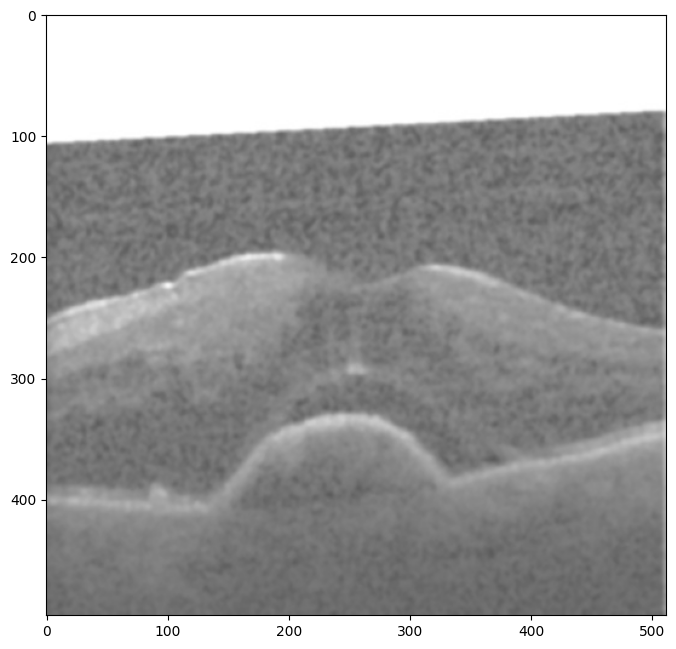

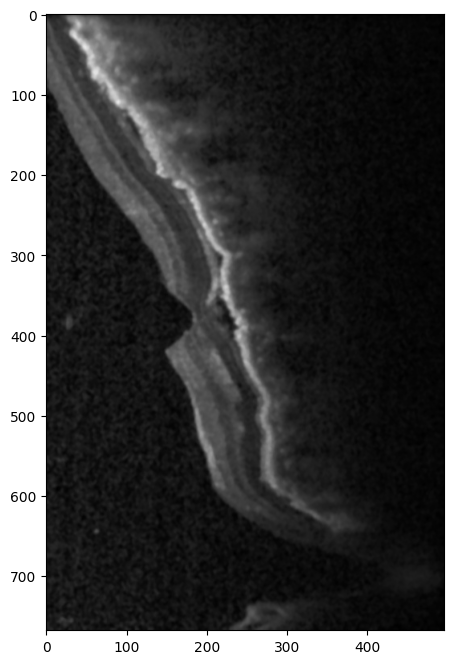

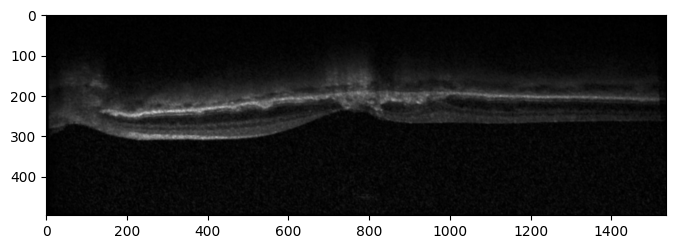

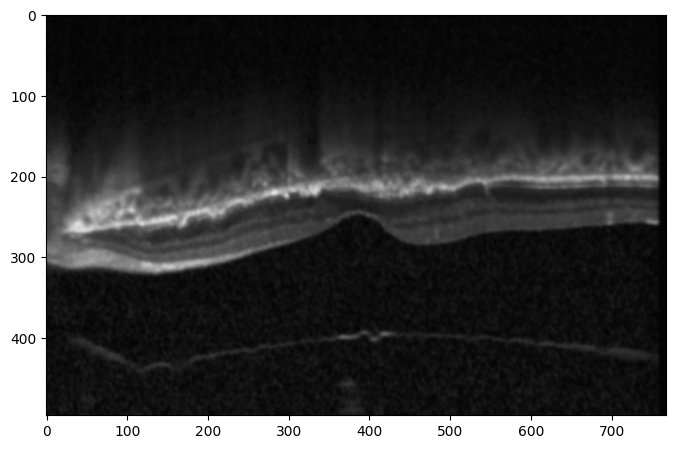

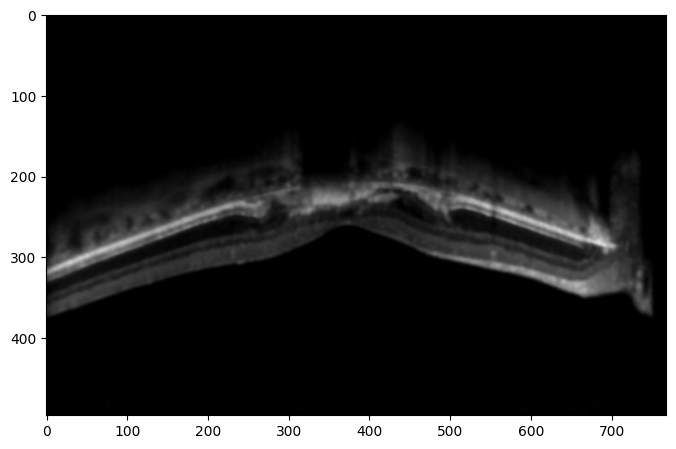

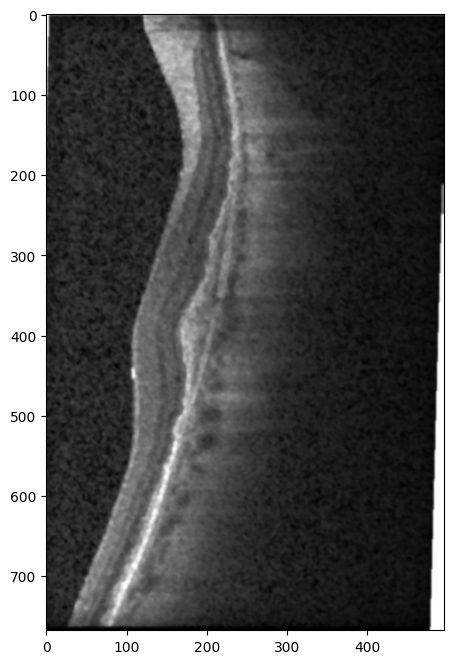

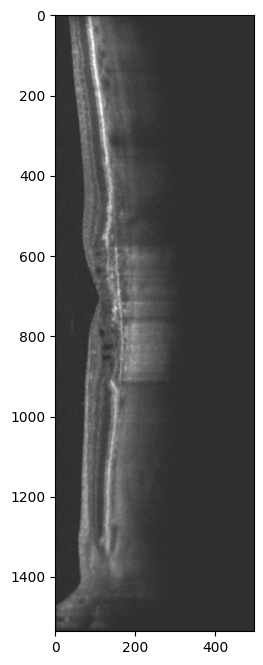

In [101]:
# affichage les 100 premières images du data_train_new pour chaque classe
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import glob

# affichage des 100 premières images du data_train_new pour chaque classe
for i in range(10):
    img = mpimg.imread(data_train_new[i])
    imgplot = plt.imshow(img)
    plt.show()

In [102]:
# importer le VGG16 et afficher le résumé du modèle
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



In [103]:
# importer le VGG16 et afficher le résumé du modèle
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [104]:
# model 
model = Sequential()
for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [106]:
# entrainer le model avec le data_train_new augmenté et tester le model avec le data_test et vaalider le model avec le data_val
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd

# data_train_new augmenté
data_train_new = 'archive/oct2017/OCT2017 /data_train_new'
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    data_train_new,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# data_test
data_test = 'archive/oct2017/OCT2017 /test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# data_val
data_val = 'archive/oct2017/OCT2017 /val'
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    data_val,
    target_size=(224, 224),
    batch_size=32,  
    class_mode='categorical',
    shuffle=False
)


Found 12797 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [112]:
numepochs = 6
batch_size = 32
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list = [earlystop,checkpoint]
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=val_generator, 
                        verbose=1,
                        callbacks = callbacks_list)

Epoch 1/6
400/400 [==============================] - 2156s 5s/step - loss: 0.7372 - accuracy: 0.6981 - val_loss: 0.3739 - val_accuracy: 0.8750
Epoch 2/6
400/400 [==============================] - 1440s 4s/step - loss: 0.7422 - accuracy: 0.6891 - val_loss: 0.3480 - val_accuracy: 0.8750
Epoch 3/6
400/400 [==============================] - 1880s 5s/step - loss: 0.7176 - accuracy: 0.6995 - val_loss: 0.2311 - val_accuracy: 0.9688
Epoch 4/6
400/400 [==============================] - 1502s 4s/step - loss: 0.6910 - accuracy: 0.7099 - val_loss: 0.2637 - val_accuracy: 0.9375
Epoch 5/6
400/400 [==============================] - 4795s 12s/step - loss: 0.6593 - accuracy: 0.7249 - val_loss: 0.1849 - val_accuracy: 0.9688
Epoch 6/6
400/400 [==============================] - 5522s 14s/step - loss: 0.6227 - accuracy: 0.7445 - val_loss: 0.1939 - val_accuracy: 0.9688


In [113]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 93s 3s/step - loss: 0.2898 - accuracy: 0.9060
Test Loss:  0.2897754907608032
Test Accuracy:  0.9059917330741882


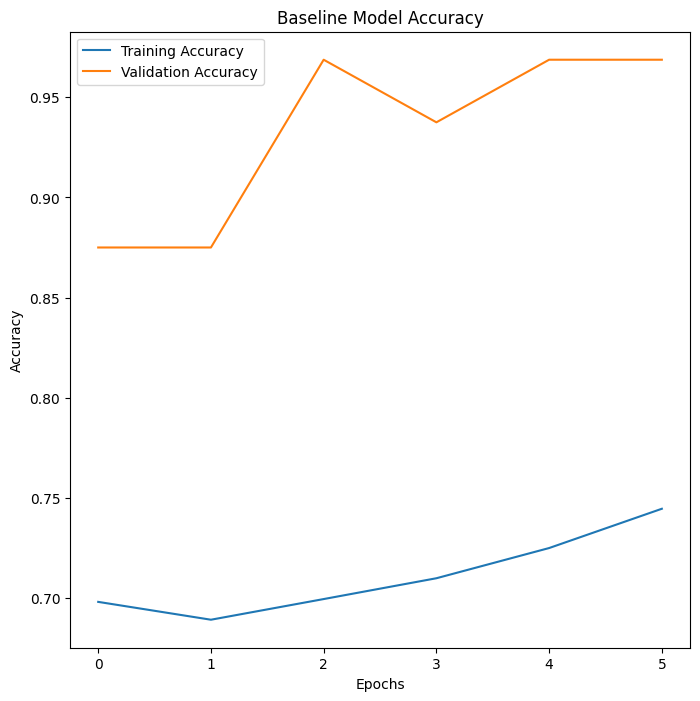

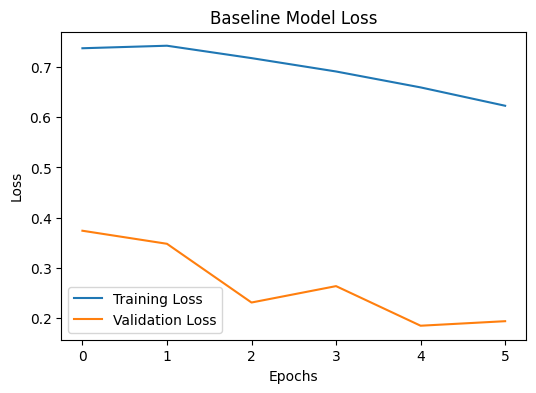

In [114]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

31/31 [==============================] - 96s 3s/step


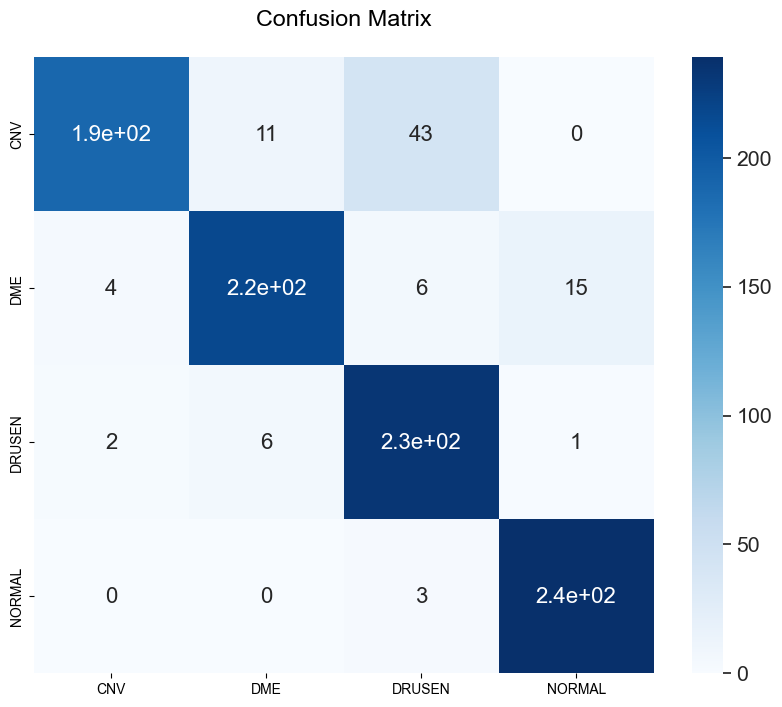

Classification Report

              precision    recall  f1-score   support

         CNV       0.97      0.78      0.86       242
         DME       0.93      0.90      0.91       242
      DRUSEN       0.82      0.96      0.88       242
      NORMAL       0.94      0.99      0.96       242

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968



In [115]:
import seaborn as sn
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [116]:
# save model and architecture to single file
model.save("vgg16-retinal-oct.h5")
print("Saved model to disk")

Saved model to disk


In [125]:
# tester le model avec une image de test
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

model = load_model('vgg16-retinal-oct.h5')

img_path = 'CNV-test.jpeg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)


In [120]:
from PIL import Image
import io
model = tf.keras.models.load_model('vgg16-retinal-oct.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
from keras.preprocessing import image

test_image = image.load_img("CNV-81630-4.jpeg", target_size = (150, 150)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(model.predict(test_image))
print(result)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(result)])

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'